In [2]:
# 데이터 불러오기
import pandas as pd
import re 

pd.set_option('display.max_rows', 10000)

df = pd.read_csv(
    "./data/202512_202512_연령별인구현황_월간.csv",
    encoding="cp949"
)

df["지역명"] = df["행정구역"].str.split("(").str[0].str.strip()
df["행정코드"] = df["행정구역"].str.extract(r"\((\d+)\)").astype("Int64")

# 3. 시/군 단위만 추출
# - 시도: code % 100_000_000 == 0
# - 시군구: code % 100_000_000 != 0 AND code % 100_000 == 0
sigungu = df[
    (df["행정코드"] % 100_000_000 != 0) &
    (df["행정코드"] % 100_000 == 0)
].copy()

# 4. 숫자 컬럼 정리
num_cols = [
    "2025년12월_계_총인구수",
    "2025년12월_계_20~24세",
    "2025년12월_계_25~29세",
    "2025년12월_계_30~34세",
]

for c in num_cols:
    sigungu[c] = (
        sigungu[c]
        .astype(str)
        .str.replace(",", "", regex=False)
        .astype(int)
    )

# 5. 청년(20~34) 인구 계산
sigungu["청년(20~34)인구"] = (
    sigungu["2025년12월_계_20~24세"]
    + sigungu["2025년12월_계_25~29세"]
    + sigungu["2025년12월_계_30~34세"]
)

sigungu["청년비율(20~34)"] = (
    sigungu["청년(20~34)인구"]
    / sigungu["2025년12월_계_총인구수"]
)

# 6. 제외할 광역 단위 정의
exclude_regions = [
    "서울특별시", "경기도", 
    "인천광역시", "광주광역시", "울산광역시",
    "부산광역시", "대구광역시", "대전광역시"
]

sigungu["상위지역"] = sigungu["지역명"].str.split().str[0]

local_sigungu = sigungu[
    ~sigungu["상위지역"].isin(exclude_regions)
].copy()

# 7. 결과 테이블 구성
result = local_sigungu[
    ["지역명", "2025년12월_계_총인구수", "청년(20~34)인구", "청년비율(20~34)"]
].rename(columns={"2025년12월_계_총인구수": "총인구"})

result["청년비율(20~34)"] = (result["청년비율(20~34)"] * 100).round(2)

# 8. 결과 출력
print("=== [지방 시/군] 청년비율(20~34) 높은 지역 TOP 20 ===")
display(result.sort_values("청년비율(20~34)", ascending=False).head(20))

print("=== [지방 시/군] 청년인구(20~34) 많은 지역 TOP 20 ===")
display(result.sort_values("청년(20~34)인구", ascending=False).head(20))

=== [지방 시/군] 청년비율(20~34) 높은 지역 TOP 20 ===


,지역명,총인구,청년(20~34)인구,청년비율(20~34)
169,충청북도 청주시 흥덕구,292051,63608,21.78
184,충청남도 천안시 서북구,401852,86596,21.55
182,충청남도 천안시,664322,136935,20.61
168,충청북도 청주시 서원구,182689,36320,19.88
166,충청북도 청주시,856152,168807,19.72
170,충청북도 청주시 청원구,186861,36270,19.41
183,충청남도 천안시 동남구,262470,50339,19.18
267,경상남도 창원시 성산구,246904,47210,19.12
147,강원특별자치도 춘천시,285234,53555,18.78
201,전북특별자치도 전주시 완산구,316419,59303,18.74


=== [지방 시/군] 청년인구(20~34) 많은 지역 TOP 20 ===


,지역명,총인구,청년(20~34)인구,청년비율(20~34)
166,충청북도 청주시,856152,168807,19.72
265,경상남도 창원시,990898,159316,16.08
182,충청남도 천안시,664322,136935,20.61
200,전북특별자치도 전주시,625437,116554,18.64
275,경상남도 김해시,533035,87433,16.40
184,충청남도 천안시 서북구,401852,86596,21.55
292,제주특별자치도 제주시,485182,82843,17.07
246,경상북도 구미시,403883,72973,18.07
240,경상북도 포항시,488707,72539,14.84
86,세종특별자치시,391965,63750,16.26


### 지방 평균보다 유독 청년이 많은 이상 지역 탐색

In [3]:
# 지방 시/군 전체의 청년 비율 평균 계산
local_avg_ratio = result["청년비율(20~34)"].mean()

# 활력 지수 생성 
result["활력 지수"] = result["청년비율(20~34)"]/local_avg_ratio

print(result.sort_values(by="활력 지수", ascending=False).head(10))

                 지역명     총인구  청년(20~34)인구  청년비율(20~34)     활력 지수
169     충청북도 청주시 흥덕구  292051        63608        21.78  1.705753
184     충청남도 천안시 서북구  401852        86596        21.55  1.687740
182         충청남도 천안시  664322       136935        20.61  1.614122
168     충청북도 청주시 서원구  182689        36320        19.88  1.556950
166         충청북도 청주시  856152       168807        19.72  1.544420
170     충청북도 청주시 청원구  186861        36270        19.41  1.520141
183     충청남도 천안시 동남구  262470        50339        19.18  1.502128
267     경상남도 창원시 성산구  246904        47210        19.12  1.497429
147      강원특별자치도 춘천시  285234        53555        18.78  1.470801
201  전북특별자치도 전주시 완산구  316419        59303        18.74  1.467669


### 총 인구와 활력지수를 두 축으로 놓고 지역을 분류
1사분면 : 인구 적음 /  청년은 많음
2사분면 : 인구 많고 / 청년 많음 
3사분면 : 인구 적고 / 청년 적음 
4사분면 : 덩치는 큰데 청년들이 없음

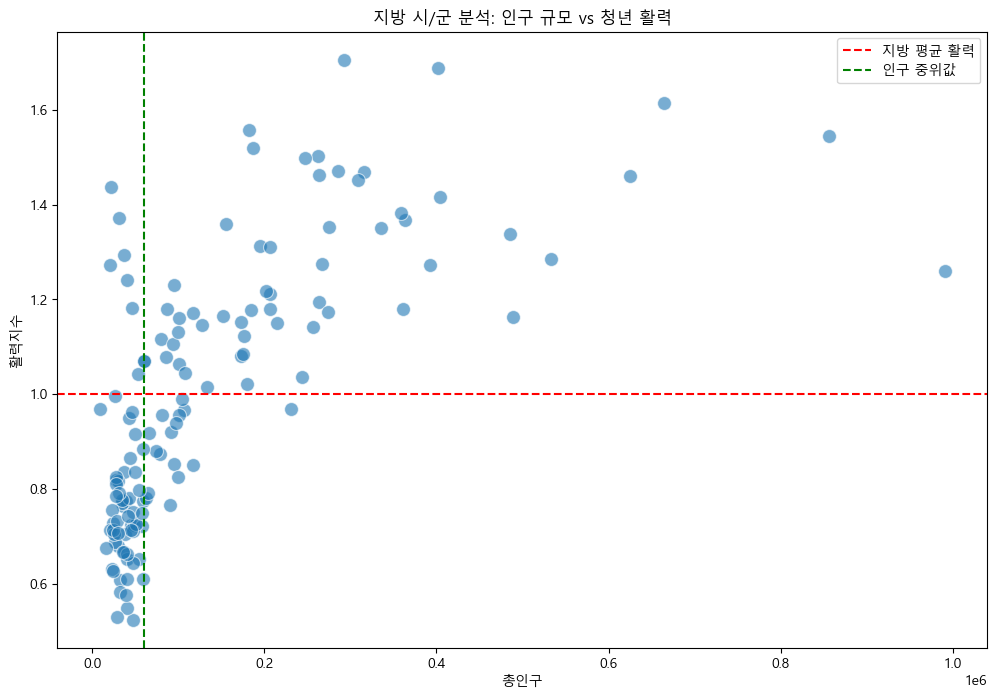

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 1. 모든 컬럼명의 앞뒤 공백 제거, 중간 공백도 없애기
# '활력 지수' -> '활력지수'
result.columns = result.columns.str.replace(" ", "").str.strip()

# 2. 숫자로 변환.
result["총인구"] = pd.to_numeric(result["총인구"])
result["활력지수"] = pd.to_numeric(result["활력지수"])

# 3. 윈도우 한글 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 4. 다시 시각화
plt.figure(figsize=(12, 8))
sns.scatterplot(data=result, x="총인구", y="활력지수", alpha=0.6, s=100)

# 기준선 추가
plt.axhline(y=1.0, color='r', linestyle='--', label='지방 평균 활력')
plt.axvline(x=result["총인구"].median(), color='g', linestyle='--', label='인구 중위값')

plt.title("지방 시/군 분석: 인구 규모 vs 청년 활력")
plt.legend()
plt.show()

인구 규모가 작지만 활력이 유독 높은 지역, 인구는 많은데 활력이 바닥인 지역 
인구 규모의 크다/작다와 활력이 높다/ 낮다의 기준 설정. 
- 인구 규모 : 중위값 기준 
- 활력 지수 : 평균값이 1.0을 기준으로 상위/하위 임계치 설정


## 해석
- 강원도 화천, 인제, 증평, 약구군, 철원군 : 인구는 중위값 이하이면서 활력 지수는 1.2 이상인 곳
- 경상북도 상주시, 전남 해남군, 경상북도 문경시 : 인구는 중위값 이상이면서 활력 지수는 0.8 이하인 곳

In [5]:
# 1. 인구 중위값 계산
population_median = result["총인구"].median()

# 2. 지역 A 추출: 인구는 중위값 이하이면서 활력 지수는 1.2 이상인 곳
region_a = result[
    (result["총인구"] <= population_median) & 
    (result["활력지수"] >= 1.2)
].sort_values("활력지수", ascending=False)

# 3. 지역 B 추출: 인구는 중위값 이상이면서 활력 지수는 0.8 이하인 곳
region_b = result[
    (result["총인구"] > population_median) & 
    (result["활력지수"] <= 0.8)
].sort_values("활력지수", ascending=True)

# 결과 출력
print(f"(총 {len(region_a)}곳)")
print(region_a.head(10))

print(f"\n(총 {len(region_b)}곳)")
print(region_b.head(10))

(총 5곳)
             지역명    총인구  청년(20~34)인구  청년비율(20~34)      활력지수
160  강원특별자치도 화천군  22371         4102        18.34  1.436342
162  강원특별자치도 인제군  30863         5404        17.51  1.371338
176     충청북도 증평군  36680         6060        16.52  1.293804
161  강원특별자치도 양구군  20410         3319        16.26  1.273441
159  강원특별자치도 철원군  39979         6331        15.84  1.240548

(총 3곳)
          지역명    총인구  청년(20~34)인구  청년비율(20~34)      활력지수
249  경상북도 상주시  89888         8797         9.79  0.766728
230  전라남도 해남군  62188         6191         9.96  0.780042
250  경상북도 문경시  65348         6609        10.11  0.791789


NameError: name 'pop_median' is not defined

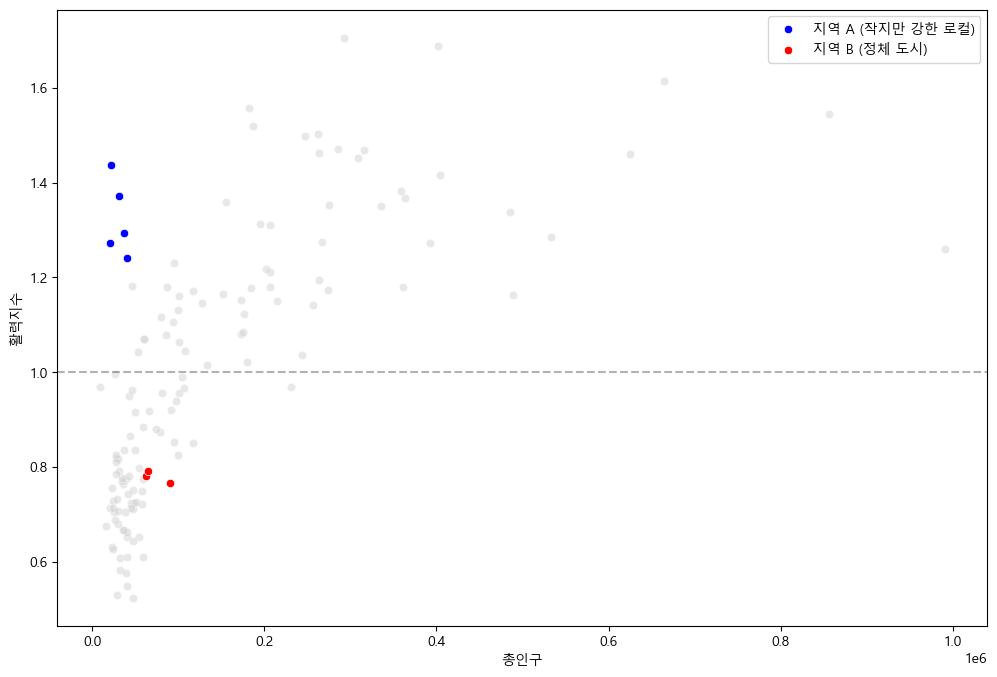

In [6]:
import matplotlib.pyplot as plt

# 기존 산점도 위에 지역 A와 B만 봄. 
plt.figure(figsize=(12, 8))
plt.rcParams['font.family'] = 'Malgun Gothic'

# 전체 분포
sns.scatterplot(data=result, x="총인구", y="활력지수", color='lightgray', alpha=0.5)

# 지역 A와 B 강조
sns.scatterplot(data=region_a, x="총인구", y="활력지수", color='blue', label='지역 A (작지만 강한 로컬)')
sns.scatterplot(data=region_b, x="총인구", y="활력지수", color='red', label='지역 B (정체 도시)')

plt.axhline(1.0, color='black', linestyle='--', alpha=0.3)
plt.axvline(pop_median, color='black', linestyle='--', alpha=0.3)
plt.legend()
plt.show()

###

 다음 액션: 순이동률 데이터랑 merge해서 상관성 꺼내기 
 데이터 병합 : pd.merge() 지역명이나 행정코드 기준으로 상관성 보기

- 청년 비중과 순 이동률이 둘다 증가한다면 유입이 늘어나서 외부 청년들이 찾는 곳
- 청년 비중은 높은데 순이동률은 줄어든다면 살던 청년들이 많지만 조금씩 유출되는 곳
- 인구도 없고 사람도 계속 떠나는 곳은 데드존 

In [7]:
import os
if not os.path.exists('./data'):
    os.makedirs('./data')

In [10]:
result.to_csv("./data/youth_poupulation.csv", index=False, encoding="cp949")
print("파일 저장 완료 : youth_population.csv")

파일 저장 완료 : youth_population.csv


In [ ]:
mi